In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import json
import os
import glob

In [2]:
dataset = []
with open('../data/clusters/bias_dataset_bfcl_format.jsonl') as f:
    data = [json.loads(line) for line in f]
print(data[0]['function'])

[{'name': 'goapis_geocoding_api.geocding', 'description': "Geocoding is the process of converting a physical address into geographic coordinates, such as latitude and longitude. It allows for the identification of a specific location on the Earth's surface, making it possible to map and analyze data spatially", 'parameters': {'type': 'object', 'properties': {'lat': {'type': 'string', 'description': ''}, 'long': {'type': 'string', 'description': ''}}, 'required': []}}, {'name': 'geocode___forward_and_reverse.forward_geocode', 'description': 'Get lat,lng coordinates from an address.', 'parameters': {'type': 'object', 'properties': {'address': {'type': 'string', 'description': ''}}, 'required': ['address']}}, {'name': 'geolocate.get_coordinates', 'description': 'GET request to the "/geocode" endpoint with an "address" parameter containing the address or place you want to geocode', 'parameters': {'type': 'object', 'properties': {'address': {'type': 'string', 'description': ''}}, 'required'

In [3]:

def plot_called_tool_index_distribution(df, attempt_number, target_tool_index=None, ax=None):
    """
    Plots the distribution of called_tool_index for a given attempt number in the dataframe.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        attempt_number (int): The attempt number to filter on.
        target_tool_index (int, optional): The index to highlight in the plot. If None, will use the first row's target_tool_index if available.
        title_prefix (str): Prefix for the plot title.
        ax (matplotlib.axes.Axes, optional): The axis to plot on. If None, creates a new figure.
    
    Returns:
        fig, ax: The figure and axis objects if ax=None, otherwise just the axis
    """
    # Filter for the specified attempt
    filtered = df[df['attempt'] == attempt_number]
    if filtered.empty:
        print(f"No data for attempt {attempt_number}")
        return None, None if ax is None else None

    # Determine target_tool_index if not provided
    if target_tool_index is None and 'target_tool_index' in filtered.columns:
        target_tool_index = filtered['target_tool_index'].iloc[0] if not filtered['target_tool_index'].isnull().all() else None
    elif target_tool_index is None and 'target_tool' in filtered.columns:
        target_tool_index = filtered['target_tool'].iloc[0]

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = None

    # Ensure all bars (0 to 4) are plotted, even if missing in value_counts
    all_indices = list(range(5))
    value_counts = filtered['called_tool_index'].value_counts().sort_index()
    # Reindex to ensure all indices 0-4 are present, fill missing with 0
    value_counts = value_counts.reindex(all_indices, fill_value=0)

    # Prepare bar colors: highlight target_tool_index in a different color
    bar_colors = []
    for idx in value_counts.index:
        if target_tool_index is not None and idx == target_tool_index:
            bar_colors.append('orange')  # Highlight color for target_tool
        else:
            bar_colors.append('lightblue') # Default color

    ax.bar(value_counts.index, value_counts.values, edgecolor='black', color=bar_colors)
    ax.set_xlabel('Called Tool Index')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Attempt {attempt_number}')
    ax.set_xticks(value_counts.index)
    ax.set_ylim(0, 100)  # Set y-axis from 0 to 100
    
    return (fig, ax) if ax is None else ax


In [ ]:
def safe_index(ls, item):
    try:
        return ls.index(item)
    except ValueError:
        return None

def plot_file(file_path):
    df = pd.read_json(file_path, lines=True)
    target_tool = df['target_tool_index'][0]
    cluster_id = df['cluster_id'][0]
    print(target_tool)
    # find index of first called tool
    df['called_tool_index'] = df.apply(
        lambda row: safe_index(list(map(lambda x: x['function']['name'], row['tools_provided'])), row['called_tool_names'][0] if row['called_tool_names'] and len(row['called_tool_names']) > 0 else -1),
        axis=1
    )

    # Get total number of unique attempts
    num_attempts = df['attempt'].nunique()
    num_rows = (num_attempts + 4) // 5  # Round up division to determine number of rows needed

    # Create a grid with enough subplots for all attempts
    _, axes = plt.subplots(num_rows, 5, figsize=(24, 5*num_rows), sharey=True)
    axes = axes.flatten()

    # Plot each attempt
    for i, attempt_number in enumerate(sorted(df['attempt'].unique())):
        plot_called_tool_index_distribution(df, attempt_number, ax=axes[i])

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Qwen3 Distribution of Index of Called Tool for Cluster {cluster_id}; file: {file_path}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def get_selection_rates(file_path):
    df = pd.read_json(file_path, lines=True)
    mean_selected = df.groupby('attempt')['target_tool_selected'].mean()
    return mean_selected

In [6]:
model = 'qwen3'
server = 'vllm'
cluster_ids = [1,2,3,8,10]
# cluster_ids = [2,3]
BASE_DIR = f'{server}/{model}'

cluster_id = 8

for file in sorted(os.listdir(BASE_DIR)):
    if f'cluster-{cluster_id}-' in file and not file.endswith('improvement_history.jsonl'):
        # plot_file(f'{BASE_DIR}/{file}')
        print(file)

cluster-8-tool-0-qwen3-8b-q0-100.jsonl
cluster-8-tool-1-qwen3-8b-q0-100.jsonl
cluster-8-tool-2-qwen3-8b-q0-100.jsonl
cluster-8-tool-3-qwen3-8b-q0-100.jsonl
cluster-8-tool-4-qwen3-8b-q0-100.jsonl


attempt
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: target_tool_selected, dtype: float64
attempt
0    0.71
1    1.00
2    0.99
3    1.00
4    0.98
5    1.00
6    0.99
7    1.00
8    1.00
9    1.00
Name: target_tool_selected, dtype: float64
attempt
0    0.00
1    0.00
2    0.00
3    0.00
4    0.00
5    0.00
6    0.01
7    0.00
8    0.04
9    0.00
Name: target_tool_selected, dtype: float64
attempt
0    0.36
1    0.37
2    0.17
3    0.30
4    0.30
5    0.25
6    0.33
7    0.30
8    0.30
9    0.36
Name: target_tool_selected, dtype: float64
attempt
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: target_tool_selected, dtype: float64
attempt
0    0.81
1    0.84
2    0.63
3    0.66
4    0.55
5    0.73
6    0.65
7    0.55
8    0.60
9    0.50
Name: target_tool_selected, dtype: float64
attempt
0    0.00
1    0.15
2    0.13
3    0.06
4    0.05
5    0.06
6    0.03
7    0.04
8    0.04
9    0.05
Name: 

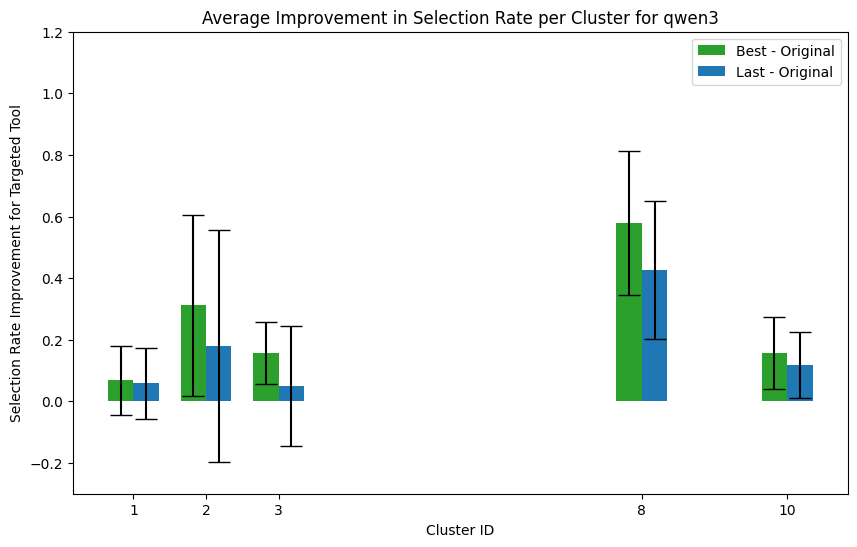

In [7]:
best_minus_original_per_cluster = []
last_minus_original_per_cluster = []

for cluster_id in cluster_ids:
    best_diffs_list = []
    last_diffs_list = []
    for file in sorted(os.listdir(BASE_DIR)):
        if f'cluster-{cluster_id}-' in file and not file.endswith('improvement_history.jsonl'):
            rates = get_selection_rates(f'{BASE_DIR}/{file}')
            print(rates)
            origin = rates.iloc[0]
            best = rates.max()
            last = rates.iloc[-1]
            best_diffs_list.append(best - origin)
            last_diffs_list.append(last - origin)
    best_minus_original_per_cluster.append(best_diffs_list)
    last_minus_original_per_cluster.append(last_diffs_list)

# Compute mean and std error for each cluster
means_best = [np.mean(vals) for vals in best_minus_original_per_cluster]
stds_best = [np.std(vals) if len(vals) > 0 else 0 for vals in best_minus_original_per_cluster]

means_last = [np.mean(vals) for vals in last_minus_original_per_cluster]
stds_last = [np.std(vals) if len(vals) > 0 else 0 for vals in last_minus_original_per_cluster]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.array(cluster_ids)
width = 0.35

ax.bar(x - width/2, means_best, yerr=stds_best, capsize=8, color='#2ca02c', width=width, label='Best - Original')
ax.bar(x + width/2, means_last, yerr=stds_last, capsize=8, color='#1f77b4', width=width, label='Last - Original')

ax.set_xlabel('Cluster ID')
ax.set_ylabel('Selection Rate Improvement for Targeted Tool')
ax.set_ylim(-0.3, 1.2)
ax.set_title(f'Average Improvement in Selection Rate per Cluster for {model}')
ax.set_xticks(x)
ax.legend()
plt.show()



In [52]:
def get_best_and_last_selection_rates(cluster_id, index, server, model):
    BASE_DIR = f'{server}/{model}'
    pattern = f'cluster-{cluster_id}-tool-{index}-*'
    files = glob.glob(os.path.join(BASE_DIR, pattern))
    selection_rate = None

    original = None
    best = None
    last = None

    for i, file in enumerate(files):
        
        if not file.endswith('improvement_history.jsonl'):
            continue
        
        # every run should have 2 files, one for improvement history and one for selection rate
        if i > 1:
            break
        df = pd.read_json(file, lines=True)
        selection_rate = df['percent']
        original = selection_rate.iloc[0]
        best = selection_rate.iloc[1:].max()
        last = selection_rate.iloc[-1]
    return original, best, last

print(get_best_and_last_selection_rates(8, 3, 'ollama', 'phi4-mini'))

(np.int64(8), np.int64(9), np.int64(6))


In [76]:
def collect_tool_selection_rates(server, model, num_clusters=10):
    data = []
    for cluster_id in range(1, num_clusters+1):
        for tool_index in range(0, 5):
            try:
                original, best, last = get_best_and_last_selection_rates(cluster_id, tool_index, server, model)
                if original is None:
                    continue
                data.append({
                    'Cluster ID': cluster_id,
                    'Tool Index': tool_index,
                    # 'Original Tool Name': tool_name,
                    'Original Selection Rate': original,
                    'Best Selection Rate': best,
                    'Improvement?': best > original,
                    # 'Last Selection Rate': last,

                })
            except Exception as e:
                print(f"Error: {e}")
                continue
    return pd.DataFrame(data)

def style_latex(df, server, model):
    df_copy = df.copy()
    # overall improvement (guard if column missing)
    improvement_percentage = df_copy['Improvement?'].mean() if 'Improvement?' in df_copy.columns else 0.0

    out = []
    out.append('% Required packages: \\usepackage{longtable,booktabs,pifont,xcolor}')
    out.append(r'\begin{longtable}{@{}l@{}}')

    caption = f"Tool selection results for {model} on {server}. \\\\ \\textbf{{Overall Improvement: {improvement_percentage*100:.2f}\\%}}"
    out.append(r'\caption{' + caption + r'} \\')

    TITLE_TEXT = 'Attack Selection Rates for ' + model + ' on ' + server

    out.append(r'\toprule')
    # out.append(r'\centering')
    out.append(r'\multicolumn{1}{c}{\textbf{' + TITLE_TEXT + r'}} \\')

    out.append(r'\midrule')
    out.append(r'\endfirsthead')

    out.append(r'\toprule')
    # out.append(r'\centering')
    out.append(r'\multicolumn{1}{c}{\textbf{' + TITLE_TEXT + r'}} \\')

    out.append(r'\midrule')
    out.append(r'\endhead')

    out.append(r'\bottomrule')
    out.append(r'\endfoot')

    # iterate clusters in sorted order
    for cluster_id in sorted(df_copy['Cluster ID'].unique()):
        cluster_df = df_copy[df_copy['Cluster ID'] == cluster_id]
        if cluster_df.empty:
            continue

        cluster_lines = []

        if cluster_id != sorted(df_copy['Cluster ID'].unique())[0]:
            cluster_lines.append(r'\vspace{2ex}')


        # centered cluster title (over the full textwidth)
        cluster_lines.append(r'\noindent{\textbf{Cluster ' + str(cluster_id) + r'}}\\[0.8ex]')

        # nested tabular with vertical bars and hlines
        cluster_lines.append(r'\begin{tabular}{|c|c|c|c|} \hline')
        cluster_lines.append(r'\textbf{Tool Index} & \textbf{OSR} & \textbf{ BSR} & \textbf{Improvement?} \\ \hline')

        # safe formatting for numeric vs text values
        def fmt_val(x):
            if pd.isna(x):
                return 'N/A'
            if isinstance(x, (int, float)):
                return f"{x:.2f}\%"
            return str(x)

        for _, row in cluster_df.iterrows():
            ti = str(row['Tool Index'])
            orig = fmt_val(row['Original Selection Rate'])
            best = fmt_val(row['Best Selection Rate'])
            imp = r'\textcolor{green}{\ding{51}}' if row['Improvement?'] else r'\textcolor{red}{\ding{55}}'
            cluster_lines.append(ti + ' & ' + orig + ' & ' + best + ' & ' + imp + r' \\ \hline')

        cluster_lines.append(r'\end{tabular}')

        # wrap the whole cluster block in a minipage (unbreakable)
        block = r'\begin{minipage}{\textwidth}' + '\n' + r'\centering'+ '\n'.join(cluster_lines) + '\n' + r'\end{minipage}'
        out.append(block + r'\\[2ex]')  # small vertical gap between clusters

    out.append(r'\end{longtable}')

    with open(f'../figures/{server}_{model}_tool_selection_rates.tex', 'w') as f:
        f.write('\n'.join(out))



    



In [77]:
# Example usage:
df_tools = collect_tool_selection_rates('ollama', 'qwen3', num_clusters=10)
display(df_tools)



server = 'ollama'
for model in ['phi4-mini', 'qwen3', 'llama']:
    df_tools = collect_tool_selection_rates(server, model, num_clusters=10)
    style_latex(df_tools, server, model)

,Cluster ID,Tool Index,Original Selection Rate,Best Selection Rate,Improvement?
0,2,0,58,99,True
1,2,1,0,11,True
2,2,2,37,96,True
3,2,3,0,7,True
4,2,4,5,47,True
5,3,0,17,25,True
6,3,1,11,15,True
7,3,2,37,41,True
8,3,3,12,52,True
9,3,4,7,17,True


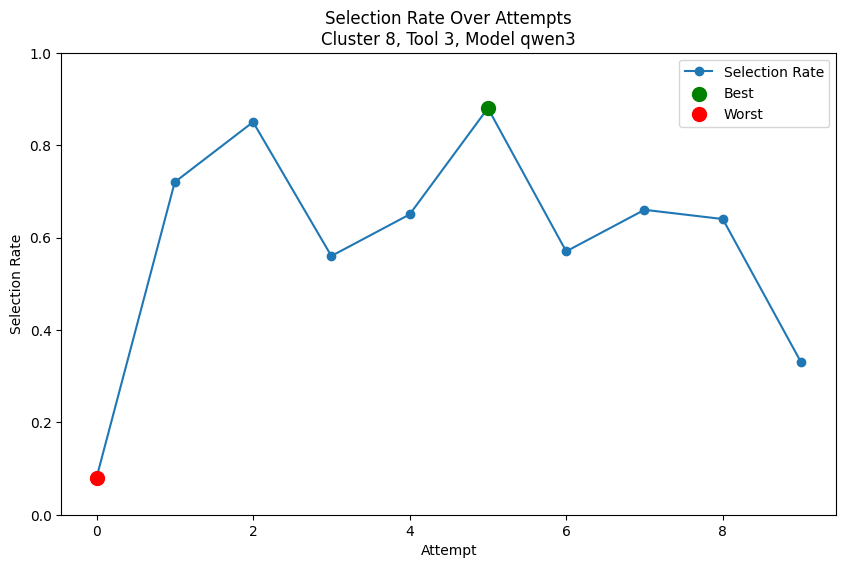

In [104]:
def plot_selection_rate_over_time(cluster_id, index, server, model):
    BASE_DIR = f'{server}/{model}'
    pattern = f'cluster-{cluster_id}-tool-{index}-*'
    files = glob.glob(os.path.join(BASE_DIR, pattern))
    selection_rate = None
    for i, file in enumerate(files):
        
        if file.endswith('improvement_history.jsonl'):
            continue

        if i > 1:
            print("Two files with the same setup. Weird")
            break

        selection_rate = get_selection_rates(file)
    # Plot selection rate over attempt, highlight best and worst performance
    attempts = np.arange(len(selection_rate))
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(attempts, selection_rate, marker='o', label='Selection Rate')

    # Highlight best (max) and worst (min) performance
    best_idx = np.argmax(selection_rate)
    worst_idx = np.argmin(selection_rate)
    ax.scatter([best_idx], [selection_rate[best_idx]], color='green', s=100, zorder=5, label='Best')
    ax.scatter([worst_idx], [selection_rate[worst_idx]], color='red', s=100, zorder=5, label='Worst')

    ax.set_xlabel('Attempt')
    ax.set_ylabel('Selection Rate')
    ax.set_ylim(0, 1)
    ax.set_title(f'Selection Rate Over Attempts\nCluster {cluster_id}, Tool {index}, Model {model}')
    ax.legend()
    plt.show()
        

plot_selection_rate_over_time(8, 3, 'vllm', 'qwen3')


In [ ]:
NOTOOL = "Hallucination or No Tool"
models = ['qwen3', 'llama']
for cluster_id in cluster_ids:
    tool_names = [f['name'] for f in data[cluster_id - 1]['function']]
    all_tool_names = tool_names + [NOTOOL]
    print(tool_names)
    cluster_stats = {}
    for model in models:
        all_counts = []
        pattern = f'cluster-{cluster_id}-*'
        files = glob.glob(os.path.join(BASE_DIR, pattern))
        
        num_files = 0
        for file in files:
            if file.endswith('improvement_history.jsonl'):
                # Skip improvement history files
                continue

            num_files += 1
            trials = pd.read_json(file, lines=True)
            trials = trials[trials['attempt'] == 0]
            trials['called_tool_name'] = trials['called_tool_names'].apply(lambda x: x[0] if x and len(x) > 0 and x[0] in tool_names else NOTOOL)

            
            counts = trials['called_tool_name'].value_counts()
            counts = counts.reindex(all_tool_names, fill_value=0)
            # print(f"Model: {model}, Cluster: {cluster_id}")
            # print(counts)

            all_counts.append(counts)
        combined = pd.concat(all_counts, axis=1)  # columns per run
        # print(combined)

        cluster_stats[model] = {
            'mean': combined.mean(axis=1),
            'std': combined.std(axis=1)
        }
    
        
            
            # For each trial, count the occurrences of each 'called_tool_name
    means_df = pd.DataFrame({model: stats['mean'] for model, stats in cluster_stats.items()})
stds_df = pd.DataFrame({model: stats['std'] for model, stats in cluster_stats.items()})


['goapis_geocoding_api.geocding', 'geocode___forward_and_reverse.forward_geocode', 'geolocate.get_coordinates', 'trueway_geocoding.geocode', 'geokeo_forward_geocoding.search.php']
['geocode___forward_and_reverse.reverse_geocode', 'forward__reverse_geocoding.reversegeocoding', 'geocoding_by_api_ninjas._v1_reversegeocoding', 'address_from_to_latitude_longitude.coordinates_latitude_longitude_to_address', 'feroeg___reverse_geocoding.reversegeocode']
['real_time_news_data.topic_headlines', 'newscatcher._v1_latest_headlines', 'theclique.top_headlines', 'newsdata.news', 'web_search.newssearch']
['whats_language.languagedetection', 'quick_language_detector.detect_language', 'text_language_by_api_ninjas._v1_textlanguage', 'translate_v3.fast_language_detection', 'translate_all_languages.detect']
['forecast.rapidapigetforecastsummarybycoordinates', 'weatherapi.com.forecast_weather_api', 'world_weather_online_api.local_weather_api', 'weather.16_day_forecast', 'weather_forecast_14_days.get_forecast

vllm/qwen3/cluster-1-tool-3-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-1-tool-1-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-1-tool-2-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-1-tool-0-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-1-tool-4-qwen3-8b-q0-100.jsonl
vllm/llama/cluster-1-tool-0-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-1-tool-1-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-1-tool-4-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-1-tool-2-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-1-tool-3-llama-3.2-3b-instruct-q0-100.jsonl


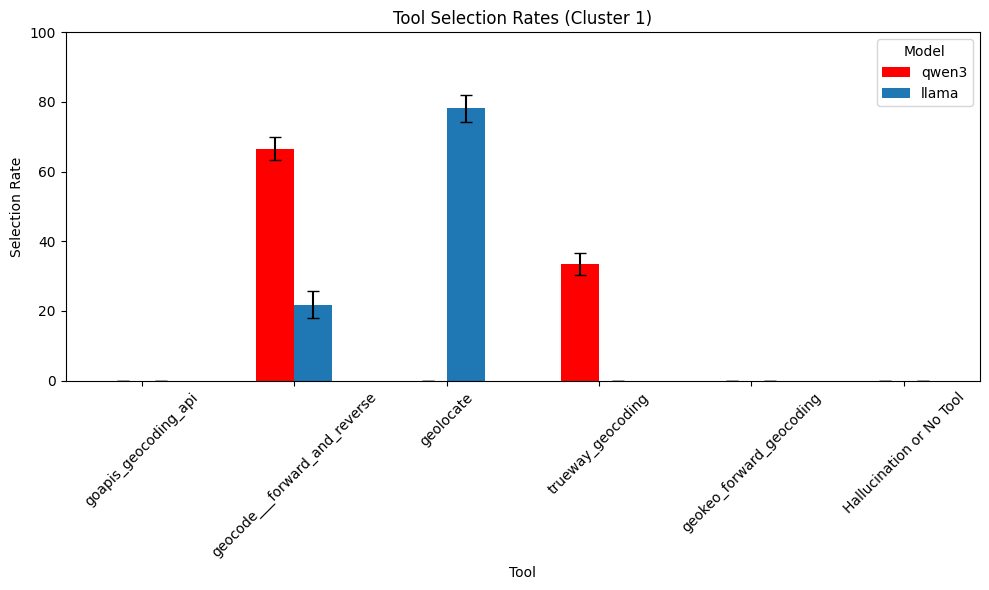

vllm/qwen3/cluster-2-tool-1-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-2-tool-3-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-2-tool-0-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-2-tool-2-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-2-tool-4-qwen3-8b-q0-100.jsonl
vllm/llama/cluster-2-tool-4-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-2-tool-2-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-2-tool-3-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-2-tool-0-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-2-tool-1-llama-3.2-3b-instruct-q0-100.jsonl


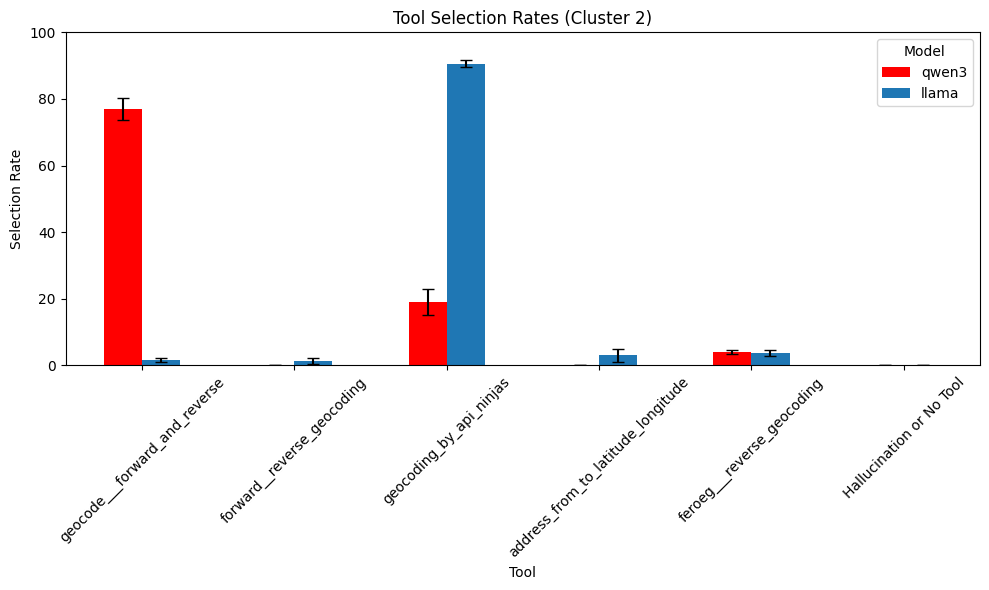

vllm/qwen3/cluster-3-tool-4-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-3-tool-2-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-3-tool-0-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-3-tool-3-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-3-tool-1-qwen3-8b-q0-100.jsonl
vllm/llama/cluster-3-tool-4-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-3-tool-2-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-3-tool-3-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-3-tool-0-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-3-tool-1-llama-3.2-3b-instruct-q0-100.jsonl


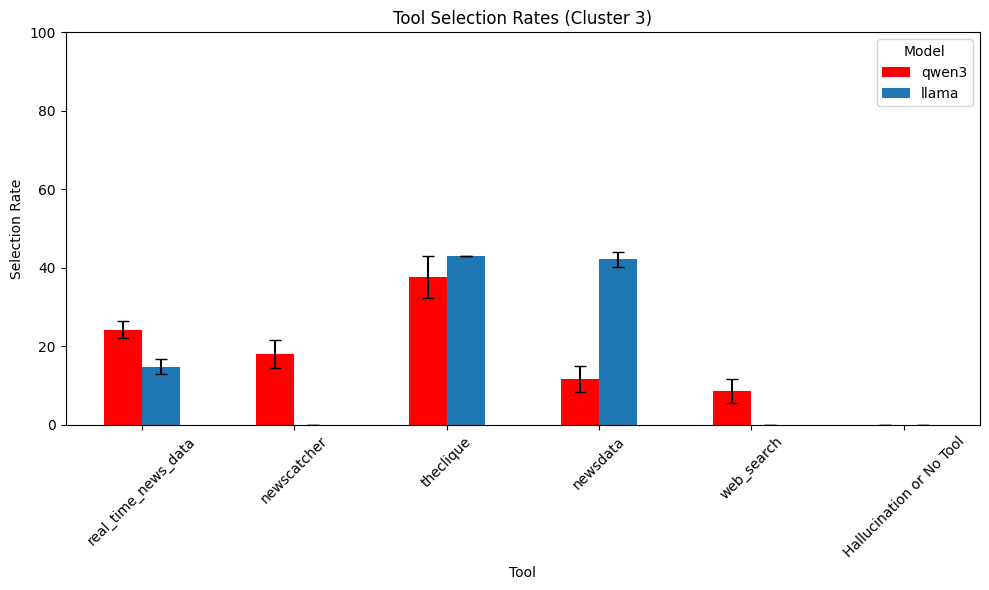

vllm/qwen3/cluster-8-tool-2-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-8-tool-0-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-8-tool-4-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-8-tool-3-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-8-tool-1-qwen3-8b-q0-100.jsonl
vllm/llama/cluster-8-tool-1-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-8-tool-0-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-8-tool-3-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-8-tool-2-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-8-tool-4-llama-3.2-3b-instruct-q0-100.jsonl


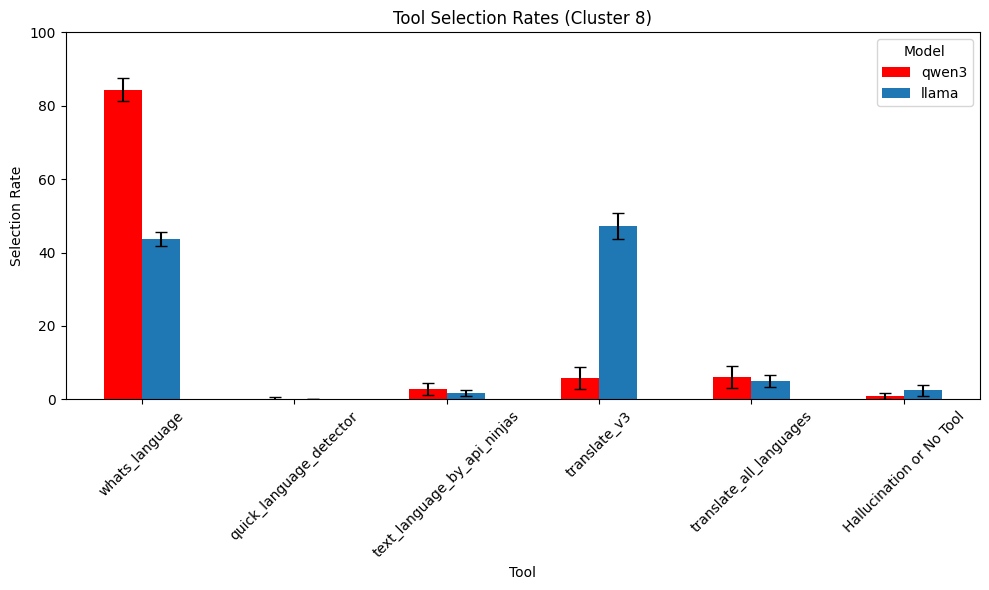

vllm/qwen3/cluster-10-tool-4-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-10-tool-2-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-10-tool-0-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-10-tool-3-qwen3-8b-q0-100.jsonl
vllm/qwen3/cluster-10-tool-1-qwen3-8b-q0-100.jsonl
vllm/llama/cluster-10-tool-3-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-10-tool-4-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-10-tool-2-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-10-tool-1-llama-3.2-3b-instruct-q0-100.jsonl
vllm/llama/cluster-10-tool-0-llama-3.2-3b-instruct-q0-100.jsonl


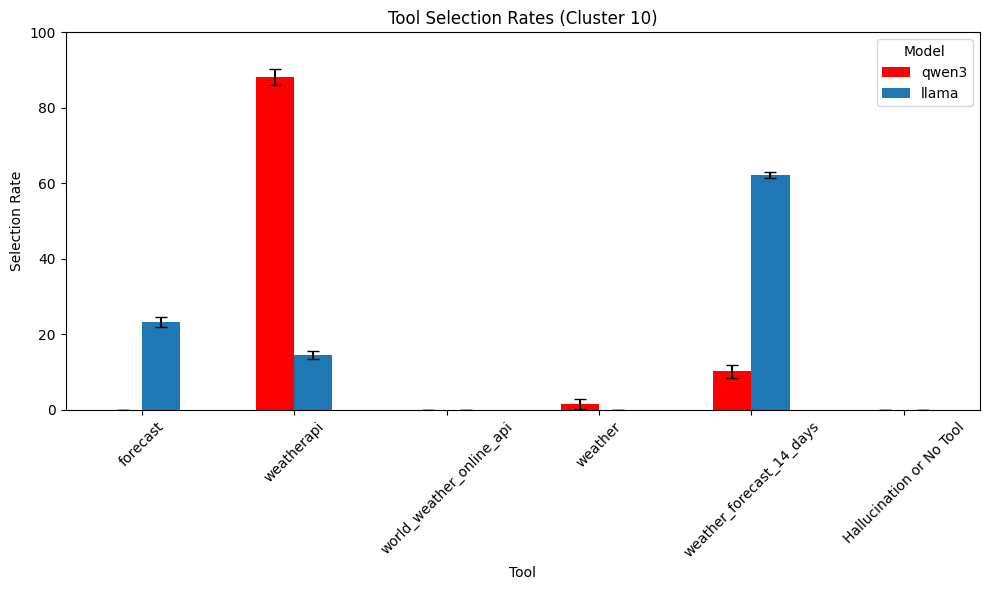

In [66]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

NOTOOL = "Hallucination or No Tool"
models = ['qwen3', 'llama']

for cluster_id in cluster_ids:
    tool_names = [f['name'] for f in data[cluster_id - 1]['function']]
    all_tool_names = tool_names + [NOTOOL]
    cluster_stats = {}

    for model in models:
        all_counts = []
        pattern = f'cluster-{cluster_id}-*'
        files = glob.glob(os.path.join(server, model, pattern))

        for file in files:
            if file.endswith('improvement_history.jsonl'):
                continue
            print(file)

            trials = pd.read_json(file, lines=True)
            trials = trials[trials['attempt'] == 0]
            trials['called_tool_name'] = trials['called_tool_names'].apply(
                lambda x: x[0].split('.')[0] if x and len(x) > 0 and x[0] in tool_names else NOTOOL
            )

            counts = trials['called_tool_name'].value_counts()
            counts = counts.reindex(map(lambda x: x.split('.')[0], all_tool_names), fill_value=0)
            all_counts.append(counts)

        if all_counts:
            combined = pd.concat(all_counts, axis=1)
            cluster_stats[model] = {
                'mean': combined.mean(axis=1),
                'std': combined.std(axis=1)
            }

    # Only plot if we have both models' data
    if len(cluster_stats) == len(models):
        means_df = pd.DataFrame({model: stats['mean'] for model, stats in cluster_stats.items()})
        stds_df = pd.DataFrame({model: stats['std'] for model, stats in cluster_stats.items()})

        # Ensure NOTOOL is last in order
        ordered_index = [t for t in means_df.index if t != NOTOOL] + [NOTOOL]
        means_df = means_df.loc[ordered_index]
        stds_df = stds_df.loc[ordered_index]

        # Set colors: qwen3 is red, llama is default (blue)
        color_map = []
        for model in means_df.columns:
            if model == 'qwen3':
                color_map.append('red')
            else:
                color_map.append('C0')  # matplotlib default blue

        ax = means_df.plot(
            kind='bar',
            yerr=stds_df,
            capsize=4,
            figsize=(10, 6),
            rot=45,
            color=color_map
        )
        ax.set_ylabel("Selection Rate")
        ax.set_xlabel("Tool")
        ax.set_ylim(0, 100)
        ax.set_title(f"Tool Selection Rates (Cluster {cluster_id})")
        ax.legend(title="Model")
        plt.tight_layout()
        plt.show()
